In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import metrics
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import KFold
from sklearn.feature_selection import RFE
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
import json
import urllib
import requests
import json
import re
import csv
from bs4 import BeautifulSoup
import urllib

%matplotlib inline

## Problem Statement: What defines a successful movie?
How can we tell if a movie is a hit before it is released on the netflix platform? There is no universal way to claim the goodness of movies. Many people rely on critics to gauge the quality of a film, while others use their instincts. But it takes the time to obtain a reasonable amount of critics review after a movie is released. And human instinct sometimes is unreliable.

Given that thousands of movies are added to the netflix library each year, is there a better way for us to tell if a movie is going to be a hit without relying on our own instincts?

## Getting the data
I decided to go with BeautifulSoup with the data gathering because I could not find a well documented API to use. Either way I would have had to collect a list of IMDB titles using a webscraper to then run through the API. With that approach I was getting many timeout errors and could not troubleshoot the errors. With this approach, using my own code, I would be much more familiar with the code and I can easily debug it and report on what is being successfully parsed and what isn't.

In [2]:
def get_list(nums=range(1,201)):
    out = []
    skip = []
    for i in nums:
        try:
            # Open the page with Beautiful Soup
            r = urllib.urlopen('http://www.imdb.com/search/title?sort=num_votes,desc&title_type=feature&page='+str(i)).read()
            soup = BeautifulSoup(r, 'lxml')
            # Find all movie divs
            movs = soup.find_all("div", class_="lister-item-content")
            all_movies = []
            # print the page number that we are about parse
            print i
            for element in movs:
                # Get the individual elements in each movie
                title = element.a.get_text()
                year = int(element.find(class_="lister-item-year").get_text()[-5:-1])
                rating = float(element.find(class_="ratings-imdb-rating").strong.get_text())
                votes_gross = element.find_all("span", {"name":"nv"})
                votes = int(votes_gross[0].get_text().replace(',', ''))
                runtime = element.find(class_="runtime").get_text()
                # Some movies did not have gross data
                try:
                    gross = round(eval(votes_gross[1].get_text().replace('$', '').replace('M', '*1000000')))
                except:
                    gross = np.nan
                # Some movies did not have a metascore
                try:
                    metascore = element.find(class_="ratings-metascore").span.get_text()
                except:
                    metascore = np.nan
                
                # 
                movie = {'title':title, 'year':year, 'rating':rating, 'votes':votes, 'gross':gross,\
                         'metascore':metascore, 'runtime':runtime}
                all_movies.append(movie)
            out = out + all_movies
        except:
            # Rather than rerunning the entire function if any page fails,
            # I am going to retrieve the skipped pages and add them to the skip list
            skip.append(i)
    print skip
    return out

In [3]:
top_10000 = get_list()
len(top_10000)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
[146, 200]


9900

In [4]:
skipped_pages = [146, 200]
skipped = get_list(skipped_pages)

146
200
[146, 200]


In [5]:
top_10000 = top_10000 + skipped

In [31]:
# cache result to avoid reloading
myfile = open('title.csv', 'wb')
wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
wr.writerow(top_10000)

## Data Exploration

In [35]:
df = pd.DataFrame(top_10000)
df.head()

,gross,metascore,rating,runtime,title,votes,year
0,28340000.0,80,9.3,142 min,The Shawshank Redemption,1723514,1994
1,533320000.0,82,9.0,152 min,The Dark Knight,1709198,2008
2,292570000.0,74,8.8,148 min,Inception,1499899,2010
3,37020000.0,66,8.8,139 min,Fight Club,1375823,1999
4,107930000.0,94,8.9,154 min,Pulp Fiction,1350200,1994


In [311]:
df.tail()

,gross,metascore,rating,runtime,title,votes,year
9895,19120000.0,35,5.4,100 min,Man of the House,20030,2005
9896,90000.0,NaN,8.0,90 min,Hiroshima Mon Amour,20021,1959
9897,NaN,NaN,8.3,90 min,Neon Genesis Evangelion: The End of Evangelion,20007,1997
9898,260000.0,63,6.7,93 min,King of California,19997,2007
9899,NaN,NaN,7.7,85 min,"Play It Again, Sam",19996,1972


In [7]:
df.describe()

/Users/Amer/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,gross,rating,votes,year
count,6.701000e+03,9900.000000,9.900000e+03,9900.000000
mean,3.591364e+07,6.622010,5.416134e+04,1996.455960
std,5.923694e+07,1.061726,1.075206e+05,18.290452
min,0.000000e+00,1.100000,4.594000e+03,1915.000000
25%,NaN,6.000000,7.769250e+03,1989.000000
50%,NaN,6.700000,1.690600e+04,2002.000000
75%,NaN,7.400000,5.077475e+04,2010.000000
max,9.366300e+08,9.700000,1.723514e+06,2016.000000


In [8]:
df.count()

gross        6701
metascore    5616
rating       9900
runtime      9900
title        9900
votes        9900
year         9900
dtype: int64

We have 4350 missing metascore values and 3255 missing gross values.

## Data Cleaning

In [36]:
# Change runtime to minutes
def intminutes(x):
    y = x.replace('min', '').strip()
    return int(y)

df.runtime = df.runtime.apply(intminutes)

In [10]:
df.dtypes

gross        float64
metascore     object
rating       float64
runtime        int64
title         object
votes          int64
year           int64
dtype: object

## Data Visualization

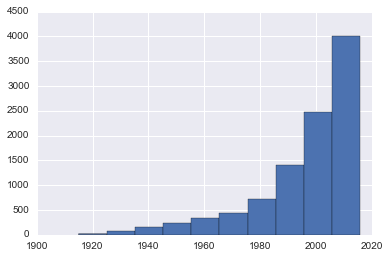

In [70]:
df['year'].hist()

We can see that our data is highly skewed to the right

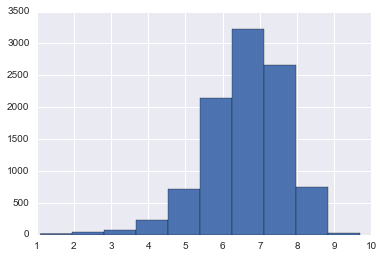

In [72]:
df['rating'].hist()

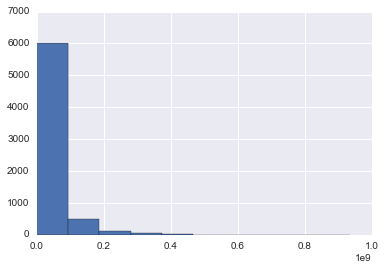

In [73]:
df['gross'].hist()

## Data Munging

In [127]:
df.head()

,gross,metascore,rating,runtime,title,votes,year
0,28340000.0,80,9.3,142,The Shawshank Redemption,1722578,1994
1,533320000.0,82,9.0,152,The Dark Knight,1708350,2008
2,292570000.0,74,8.8,148,Inception,1499024,2010
3,37020000.0,66,8.8,139,Fight Club,1375013,1999
4,107930000.0,94,8.9,154,Pulp Fiction,1349493,1994


In [13]:
bins = [1910, 2000, 2020]
group_names = ['pre_2000', 'post_2000']

categories = pd.cut(df['year'], bins, labels=group_names)
df['year'] = pd.cut(df['year'], bins, labels=group_names)

In [14]:
pd.value_counts(df['year'])

post_2000    5438
pre_2000     4462
Name: year, dtype: int64

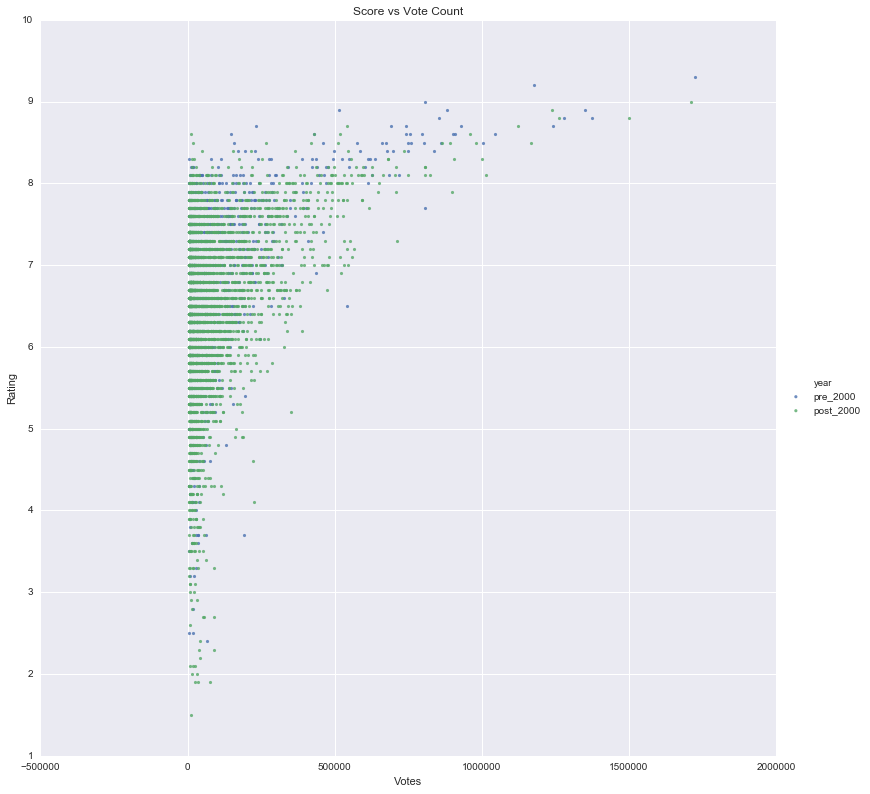

In [34]:
df_filtered = df.dropna()
sns.lmplot('votes', 'rating', 
           data=df_filtered, 
           fit_reg=False, 
           hue="year",
           size=11,
           scatter_kws={"s": 10})
plt.title('Score vs Vote Count')
plt.xlabel('Votes')
plt.ylabel('Rating')

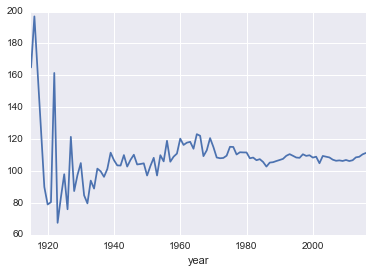

In [37]:
df.groupby(['year'])['runtime'].mean().plot()

In [16]:
df_year = pd.get_dummies(df['year'], prefix='Year')
df = df.join(df_year.ix[:, :"Year_pre_2000"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9900 entries, 0 to 9899
Data columns (total 8 columns):
gross            6701 non-null float64
metascore        5616 non-null object
rating           9900 non-null float64
runtime          9900 non-null int64
title            9900 non-null object
votes            9900 non-null int64
year             9900 non-null category
Year_pre_2000    9900 non-null float64
dtypes: category(1), float64(3), int64(2), object(2)
memory usage: 551.2+ KB


Add a "is hit" column to be able to specify if something is a hit or not. I chose 8.0 as the hit threshold arbitrarily (4/5 on netflix)

In [61]:
df['hit'] = df['rating'] > 6.9
df.hit = df.hit.astype(int)

## Modeling
I don't like the idea of dropping all the nans, so after a bit of research I am going to fill the values using Imputation and compare the scores of each type of regression.

In [62]:
df.head()

,gross,metascore,rating,runtime,title,votes,year,hit
0,28340000.0,80,9.3,142,The Shawshank Redemption,1723514,1994,1
1,533320000.0,82,9.0,152,The Dark Knight,1709198,2008,1
2,292570000.0,74,8.8,148,Inception,1499899,2010,1
3,37020000.0,66,8.8,139,Fight Club,1375823,1999,1
4,107930000.0,94,8.9,154,Pulp Fiction,1350200,1994,1


In [63]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, RandomForestRegressor

def cross_val(model, X, y):
    s = cross_val_score(model, X, y)
    print("{} Score:\t{:0.3} ± {:0.3}".format(type(model), s.mean().round(3), s.std().round(3)))

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
nc = [x for x in df.columns if x in ['gross', 'runtime', 'metascore', 'votes']]
# Estimate the scores without the missing values
df_filtered = df.dropna()
X_filtered = df_filtered[nc]
y_filtered = df_filtered.hit

dt = DecisionTreeClassifier(class_weight='balanced')
cross_val(dt, X_filtered, y_filtered)
rforest = RandomForestRegressor(random_state=0, n_estimators=100)
cross_val(rforest, X_filtered, y_filtered)
bagger = BaggingClassifier(dt, max_samples=1.0)
cross_val(bagger, X_filtered, y_filtered)
forest = RandomForestClassifier(class_weight='balanced', n_jobs=-1, n_estimators=10)
cross_val(forest, X_filtered, y_filtered)
trees = ExtraTreesClassifier(class_weight='balanced', n_jobs=-1)
cross_val(trees, X_filtered, y_filtered)


<class 'sklearn.tree.tree.DecisionTreeClassifier'> Score:	0.479 ± 0.103
<class 'sklearn.ensemble.forest.RandomForestRegressor'> Score:	0.323 ± 0.049
<class 'sklearn.ensemble.bagging.BaggingClassifier'> Score:	0.483 ± 0.103
<class 'sklearn.ensemble.forest.RandomForestClassifier'> Score:	0.498 ± 0.1
<class 'sklearn.ensemble.forest.ExtraTreesClassifier'> Score:	0.538 ± 0.116


We have a high score here, it will be hard to beat.

In [66]:
# Estimate the scores after imputation of the missing values
X_full, y_full = df[nc], df.hit

estimator = Pipeline([("imputer", Imputer(missing_values=0, strategy="mean",axis=0)),
                      ("forest", DecisionTreeClassifier(class_weight='balanced'))])
cross_val(estimator, X_full, y_full)

estimator = Pipeline([("imputer", Imputer(missing_values=0, strategy="mean",axis=0)),
                      ("forest", RandomForestRegressor(random_state=0, n_estimators=100))])
cross_val(estimator, X_full, y_full)

estimator = Pipeline([("imputer", Imputer(missing_values=0, strategy="mean",axis=0)),
                      ("forest", bagger)])
cross_val(estimator, X_full, y_full)
estimator = Pipeline([("imputer", Imputer(missing_values=0, strategy="mean",axis=0)),
                      ("forest", forest)])
cross_val(estimator, X_full, y_full)
estimator = Pipeline([("imputer", Imputer(missing_values=0, strategy="mean",axis=0)),
                      ("forest", trees)])
cross_val(estimator, X_full, y_full)


<class 'sklearn.pipeline.Pipeline'> Score:	0.465 ± 0.082
<class 'sklearn.pipeline.Pipeline'> Score:	-0.142 ± 0.034
<class 'sklearn.pipeline.Pipeline'> Score:	0.464 ± 0.083
<class 'sklearn.pipeline.Pipeline'> Score:	0.464 ± 0.083
<class 'sklearn.pipeline.Pipeline'> Score:	0.483 ± 0.083


It is clear that it would be better to drop the missing values

I decided to implement boosting to see if it would improve our models

In [67]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

In [68]:
gb = GradientBoostingClassifier()
ab = AdaBoostClassifier()
cross_val(gb, X_filtered, y_filtered)
cross_val(ab, X_filtered, y_filtered)


<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'> Score:	0.48 ± 0.104
<class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'> Score:	0.508 ± 0.097


It did not improve our model, so we will return to the bagging classifier.

I am curious about logistic modeling considering our model data are not normalized. So I created 2 pipelines, with a scaling preprocessing step and then a bagging decision tree.

In [45]:
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

In [69]:
pipedt = make_pipeline(RobustScaler(),
                       DecisionTreeClassifier())
cross_val(pipedt, X_filtered, y_filtered)

pipebdt = make_pipeline(RobustScaler(),
                        BaggingClassifier(DecisionTreeClassifier()))
cross_val(pipebdt, X_filtered, y_filtered)

<class 'sklearn.pipeline.Pipeline'> Score:	0.478 ± 0.104
<class 'sklearn.pipeline.Pipeline'> Score:	0.483 ± 0.103


The scores are worse than the non-scaled data. So there is no need to pursue normalized data modeling.

In [70]:
float(len(df_filtered[df_filtered['hit'] != 1]))/float(len(df_filtered['hit']))

0.6227120645542216

Grid search is a great way to improve the performance of a classifier. I explored the parameter space of both the Decision Tree and Bagging Classifier models to see if I can improve their performance.

In [71]:
from sklearn.grid_search import GridSearchCV

In [72]:
# Initialize a GridSearchCV with 5-fold cross validation for the Decision Tree Classifier
params = {"max_depth": [3,5,10,20],
          "max_features": [None, "auto"],
          "min_samples_leaf": [1, 3, 5, 7, 10],
          "min_samples_split": [2, 5, 7]
         }
    

gsdt = GridSearchCV(dt, params, n_jobs=-1, cv=5)

In [73]:
gsdt.fit(X_filtered, y_filtered)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [None, 'auto'], 'min_samples_split': [2, 5, 7], 'max_depth': [3, 5, 10, 20], 'min_samples_leaf': [1, 3, 5, 7, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [74]:
# Search for few values of the parameters in order to improve the score of the classifier
gsdt.best_params_

{'max_depth': 3,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 7}

In [75]:
gsdt.best_score_

0.76835268647903954

The best_score_ is not better than before (0.863).

Going back to our initial decision tree. Let's look at the most important features.

In [76]:
from IPython.display import Image
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
import pydot
dot_data = StringIO()  
export_graphviz(treeclf, out_file=dot_data,  
                feature_names=feature_cols,  
                filled=True, rounded=True,  
                special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

NameError: name 'treeclf' is not defined

In [77]:
bagger.get_params()

{'base_estimator': DecisionTreeClassifier(class_weight='balanced', criterion='gini',
             max_depth=None, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best'),
 'base_estimator__class_weight': 'balanced',
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': None,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__presort': False,
 'base_estimator__random_state': None,
 'base_estimator__splitter': 'best',
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [78]:
# I initialized a GridSearchCV with 5-fold cross validation for the Bagging Decision Tree Classifier
# and repeated the search
params = {"base_estimator__max_depth": [3,5,10,20],
          "base_estimator__max_features": [None, "auto"],
          "base_estimator__min_samples_leaf": [1, 3, 5, 7, 10],
          "base_estimator__min_samples_split": [2, 5, 7],
          'bootstrap_features': [False, True],
          'max_features': [0.5, 0.7, 1.0],
          'max_samples': [0.5, 0.7, 1.0],
          'n_estimators': [2, 5, 10, 20],
         }
    

gsbdt = GridSearchCV(bagger, params, n_jobs=-1, cv=5)

In [80]:
gsbdt.fit(X_filtered, y_filtered)

GridSearchCV(cv=5, error_score='raise',
       estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=...n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [2, 5, 10, 20], 'max_samples': [0.5, 0.7, 1.0], 'base_estimator__min_samples_split': [2, 5, 7], 'base_estimator__max_depth': [3, 5, 10, 20], 'bootstrap_features': [False, True], 'max_features': [0.5, 0.7, 1.0], 'base_estimator__min_samples_leaf': [1, 3, 5, 7, 10], 'base_estimator__max_features': [None, 'auto']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [281]:
gsbdt.best_params_

{'base_estimator__max_depth': 20,
 'base_estimator__max_features': 'auto',
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'bootstrap_features': False,
 'max_features': 0.7,
 'max_samples': 1.0,
 'n_estimators': 2}

In [282]:
gsbdt.best_score_

0.93480401812093761

The grid search bagging classifier is the best score

In [79]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
bagger_clf = BaggingClassifier(knn_clf)

print "Knn Score:\t", cross_val_score(knn_clf, X_filtered, y_filtered, cv=10, n_jobs=-1).mean()
print "Bagging Score:\t", cross_val_score(bagger_clf, X_filtered, y_filtered, cv=10, n_jobs=-1).mean()

Knn Score:	0.598271051801
Bagging Score:	0.600048911483


In [331]:
# I initialized a GridSearchCV with 5-fold cross validation for the Bagging KNN Classifier
# and repeated the search
params = {"base_estimator__max_depth": [3,5,10,20],
          "base_estimator__max_features": [None, "auto"],
          "base_estimator__min_samples_leaf": [1, 3, 5, 7, 10],
          "base_estimator__min_samples_split": [2, 5, 7],
          'bootstrap_features': [False, True],
          'max_features': [0.5, 0.7, 1.0],
          'max_samples': [0.5, 0.7, 1.0],
          'n_estimators': [2, 5, 10, 20],
         }

gsbknn = GridSearchCV(bagger_clf, params, n_jobs=-1, cv=5)

In [332]:
gsbknn.fit(X_filtered, y_filtered)

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/Amer/anaconda/lib/python2.7/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    169     pkg_name = mod_name.rpartition('.')[0]
    170     main_globals = sys.modules["__main__"].__dict__
    171     if alter_argv:
    172         sys.argv[0] = fname
    173     return _run_code(code, main_globals, None,
--> 174                      "__main__", fname, loader, pkg_name)
        fname = '/Users/Amer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py'
        loader = <pkgutil.ImpLoader instance>
        pkg_name = 'ipykernel'
    175 
    176 def run_module(mod_name, init_globals=None,
    177                run_name=None, alter_sys=False):
    178     """Execute a module's code without importing it

...........................................................................
/Users/Amer/anaconda/lib/python2.7/runpy.py in _run_code(code=<code object <module> at 0x1007cf1b0, file "/Use...2.7/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': '/Users/Amer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'ipykernel', 'app': <module 'ipykernel.kernelapp' from '/Users/Amer/...python2.7/site-packages/ipykernel/kernelapp.pyc'>}, init_globals=None, mod_name='__main__', mod_fname='/Users/Amer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py', mod_loader=<pkgutil.ImpLoader instance>, pkg_name='ipykernel')
     67         run_globals.update(init_globals)
     68     run_globals.update(__name__ = mod_name,
     69                        __file__ = mod_fname,
     70                        __loader__ = mod_loader,
     71                        __package__ = pkg_name)
---> 72     exec code in run_globals
        code = <code object <module> at 0x1007cf1b0, file "/Use...2.7/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': '/Users/Amer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'ipykernel', 'app': <module 'ipykernel.kernelapp' from '/Users/Amer/...python2.7/site-packages/ipykernel/kernelapp.pyc'>}
     73     return run_globals
     74 
     75 def _run_module_code(code, init_globals=None,
     76                     mod_name=None, mod_fname=None,

...........................................................................
/Users/Amer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/Users/Amer/anaconda/lib/python2.7/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    591         
    592         If a global instance already exists, this reinitializes and starts it
    593         """
    594         app = cls.instance(**kwargs)
    595         app.initialize(argv)
--> 596         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    597 
    598 #-----------------------------------------------------------------------------
    599 # utility functions, for convenience
    600 #-----------------------------------------------------------------------------

...........................................................................
/Users/Amer/anaconda/lib/python2.7/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    437         
    438         if self.poller is not None:
    439             self.poller.start()
    440         self.kernel.start()
    441         try:
--> 442             ioloop.IOLoop.instance().start()
    443         except KeyboardInterrupt:
    444             pass
    445 
    446 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/Amer/anaconda/lib/python2.7/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    157             PollIOLoop.configure(ZMQIOLoop)
    158         return PollIOLoop.current(*args, **kwargs)
    159     
    160     def start(self):
    161         try:
--> 162             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    163         except ZMQError as e:
    164             if e.errno == ETERM:
    165                 # quietly return on ETERM
    166                 pass

...........................................................................
/Users/Amer/anaconda/lib/python2.7/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    878                 self._events.update(event_pairs)
    879                 while self._events:
    880                     fd, events = self._events.popitem()
    881                     try:
    882                         fd_obj, handler_func = self._handlers[fd]
--> 883                         handler_func(fd_obj, events)
        handler_func = <function null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    884                     except (OSError, IOError) as e:
    885                         if errno_from_exception(e) == errno.EPIPE:
    886                             # Happens when the client closes the connection
    887                             pass

...........................................................................
/Users/Amer/anaconda/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/Users/Amer/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/Users/Amer/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/Users/Amer/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/Users/Amer/anaconda/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/Users/Amer/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/Amer/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {u'allow_stdin': True, u'code': u'gsbknn.fit(X_filtered, y_filtered)', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2016-11-02T12:36:05.008999', u'msg_id': u'2D46D038B695439E8D8B0A7D8D2C2524', u'msg_type': u'execute_request', u'session': u'97319A95123E4A9288162890901AD5C8', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'2D46D038B695439E8D8B0A7D8D2C2524', 'msg_type': u'execute_request', 'parent_header': {}})
    223             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method IPythonKernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = ['97319A95123E4A9288162890901AD5C8']
        msg = {'buffers': [], 'content': {u'allow_stdin': True, u'code': u'gsbknn.fit(X_filtered, y_filtered)', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2016-11-02T12:36:05.008999', u'msg_id': u'2D46D038B695439E8D8B0A7D8D2C2524', u'msg_type': u'execute_request', u'session': u'97319A95123E4A9288162890901AD5C8', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'2D46D038B695439E8D8B0A7D8D2C2524', 'msg_type': u'execute_request', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
/Users/Amer/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=['97319A95123E4A9288162890901AD5C8'], parent={'buffers': [], 'content': {u'allow_stdin': True, u'code': u'gsbknn.fit(X_filtered, y_filtered)', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2016-11-02T12:36:05.008999', u'msg_id': u'2D46D038B695439E8D8B0A7D8D2C2524', u'msg_type': u'execute_request', u'session': u'97319A95123E4A9288162890901AD5C8', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'2D46D038B695439E8D8B0A7D8D2C2524', 'msg_type': u'execute_request', 'parent_header': {}})
    386         if not silent:
    387             self.execution_count += 1
    388             self._publish_execute_input(code, parent, self.execution_count)
    389 
    390         reply_content = self.do_execute(code, silent, store_history,
--> 391                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    392 
    393         # Flush output before sending the reply.
    394         sys.stdout.flush()
    395         sys.stderr.flush()

...........................................................................
/Users/Amer/anaconda/lib/python2.7/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code=u'gsbknn.fit(X_filtered, y_filtered)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    194 
    195         reply_content = {}
    196         # FIXME: the shell calls the exception handler itself.
    197         shell._reply_content = None
    198         try:
--> 199             shell.run_cell(code, store_history=store_history, silent=silent)
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = u'gsbknn.fit(X_filtered, y_filtered)'
        store_history = True
        silent = False
    200         except:
    201             status = u'error'
    202             # FIXME: this code right now isn't being used yet by default,
    203             # because the run_cell() call above directly fires off exception

...........................................................................
/Users/Amer/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell=u'gsbknn.fit(X_filtered, y_filtered)', store_history=True, silent=False, shell_futures=True)
   2718                 self.displayhook.exec_result = result
   2719 
   2720                 # Execute the user code
   2721                 interactivity = "none" if silent else self.ast_node_interactivity
   2722                 self.run_ast_nodes(code_ast.body, cell_name,
-> 2723                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler instance>
   2724 
   2725                 # Reset this so later displayed values do not modify the
   2726                 # ExecutionResult
   2727                 self.displayhook.exec_result = None

...........................................................................
/Users/Amer/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>], cell_name='<ipython-input-332-fe133af1b14f>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler instance>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   2826                     return True
   2827 
   2828             for i, node in enumerate(to_run_interactive):
   2829                 mod = ast.Interactive([node])
   2830                 code = compiler(mod, cell_name, "single")
-> 2831                 if self.run_code(code, result):
        self.run_code = <bound method ZMQInteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x11acf23b0, file "<ipython-input-332-fe133af1b14f>", line 1>
        result = <IPython.core.interactiveshell.ExecutionResult object>
   2832                     return True
   2833 
   2834             # Flush softspace
   2835             if softspace(sys.stdout, 0):

...........................................................................
/Users/Amer/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x11acf23b0, file "<ipython-input-332-fe133af1b14f>", line 1>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   2880         outflag = 1  # happens in more places, so it's easier as default
   2881         try:
   2882             try:
   2883                 self.hooks.pre_run_code_hook()
   2884                 #rprint('Running code', repr(code_obj)) # dbg
-> 2885                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x11acf23b0, file "<ipython-input-332-fe133af1b14f>", line 1>
        self.user_global_ns = {'AdaBoostClassifier': <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>, 'BaggingClassifier': <class 'sklearn.ensemble.bagging.BaggingClassifier'>, 'BeautifulSoup': <class 'bs4.BeautifulSoup'>, 'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'ExtraTreesClassifier': <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>, 'GradientBoostingClassifier': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, 'GridSearchCV': <class 'sklearn.grid_search.GridSearchCV'>, 'Image': <class 'IPython.core.display.Image'>, 'Imputer': <class 'sklearn.preprocessing.imputation.Imputer'>, 'In': ['', u"import numpy as np\nimport pandas as pd\nimpor...lib\n\nget_ipython().magic(u'matplotlib inline')", u'def get_list(num=201):\n    out = []\n    skip...  skip.append(i)\n    print skip\n    return out', u'top_10000 = get_list()\nlen(top_10000)', u'def get_list(num=201):\n    out = []\n    skip...  skip.append(i)\n    print skip\n    return out', u'top_10000 = get_list()\nlen(top_10000)', u'def get_list(num=201):\n    out = []\n    skip...  skip.append(i)\n    print skip\n    return out', u'top_10000 = get_list()\nlen(top_10000)', u'top_10000.head(150)', u'top_10000[1:10]', u'top_10000[1:150]', u'# Rather than rerunning the entire function I ...  skip.append(i)\n    print skip\n    return out', u'skipped_pages = [7, 18, 20, 39, 64, 73, 81, 86...91, 198, 200]\nskipped = get_list(skipped_pages)', u'skipped_pages = [7, 18, 20, 39, 64, 73, 81, 86...91, 198, 200]\nskipped = get_list(skipped_pages)', u'skipped_pages = [7, 18, 20, 39, 64, 73, 81, 86...91, 198, 200]\nskipped = get_list(skipped_pages)', u'top_10000 = top_10000 + skipped', u"# cache result to avoid reloading\nmyfile = op..., quoting=csv.QUOTE_ALL)\nwr.writerow(top_10000)", u'df = pd.DataFrame(top_10000)\ndf.head()', u'df.describe', u'df.describe()', ...], ...}
        self.user_ns = {'AdaBoostClassifier': <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>, 'BaggingClassifier': <class 'sklearn.ensemble.bagging.BaggingClassifier'>, 'BeautifulSoup': <class 'bs4.BeautifulSoup'>, 'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'ExtraTreesClassifier': <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>, 'GradientBoostingClassifier': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, 'GridSearchCV': <class 'sklearn.grid_search.GridSearchCV'>, 'Image': <class 'IPython.core.display.Image'>, 'Imputer': <class 'sklearn.preprocessing.imputation.Imputer'>, 'In': ['', u"import numpy as np\nimport pandas as pd\nimpor...lib\n\nget_ipython().magic(u'matplotlib inline')", u'def get_list(num=201):\n    out = []\n    skip...  skip.append(i)\n    print skip\n    return out', u'top_10000 = get_list()\nlen(top_10000)', u'def get_list(num=201):\n    out = []\n    skip...  skip.append(i)\n    print skip\n    return out', u'top_10000 = get_list()\nlen(top_10000)', u'def get_list(num=201):\n    out = []\n    skip...  skip.append(i)\n    print skip\n    return out', u'top_10000 = get_list()\nlen(top_10000)', u'top_10000.head(150)', u'top_10000[1:10]', u'top_10000[1:150]', u'# Rather than rerunning the entire function I ...  skip.append(i)\n    print skip\n    return out', u'skipped_pages = [7, 18, 20, 39, 64, 73, 81, 86...91, 198, 200]\nskipped = get_list(skipped_pages)', u'skipped_pages = [7, 18, 20, 39, 64, 73, 81, 86...91, 198, 200]\nskipped = get_list(skipped_pages)', u'skipped_pages = [7, 18, 20, 39, 64, 73, 81, 86...91, 198, 200]\nskipped = get_list(skipped_pages)', u'top_10000 = top_10000 + skipped', u"# cache result to avoid reloading\nmyfile = op..., quoting=csv.QUOTE_ALL)\nwr.writerow(top_10000)", u'df = pd.DataFrame(top_10000)\ndf.head()', u'df.describe', u'df.describe()', ...], ...}
   2886             finally:
   2887                 # Reset our crash handler in place
   2888                 sys.excepthook = old_excepthook
   2889         except SystemExit as e:

...........................................................................
/Users/Amer/Sites/GA/GA-DSI/projects/projects-weekly/project-06/<ipython-input-332-fe133af1b14f> in <module>()
----> 1 
      2 
      3 
      4 
      5 
      6 gsbknn.fit(X_filtered, y_filtered)
      7 
      8 
      9 
     10 

...........................................................................
/Users/Amer/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py in fit(self=GridSearchCV(cv=5, error_score='raise',
       e...='2*n_jobs', refit=True, scoring=None, verbose=0), X=            gross    metascore  runtime    votes...             93    19997

[5077 rows x 4 columns], y=0       1
1       1
2       1
3       1
4       ...    0
9895    0
9898    0
Name: hit, dtype: int64)
    799         y : array-like, shape = [n_samples] or [n_samples, n_output], optional
    800             Target relative to X for classification or regression;
    801             None for unsupervised learning.
    802 
    803         """
--> 804         return self._fit(X, y, ParameterGrid(self.param_grid))
        self._fit = <bound method GridSearchCV._fit of GridSearchCV(...'2*n_jobs', refit=True, scoring=None, verbose=0)>
        X =             gross    metascore  runtime    votes...             93    19997

[5077 rows x 4 columns]
        y = 0       1
1       1
2       1
3       1
4       ...    0
9895    0
9898    0
Name: hit, dtype: int64
        self.param_grid = {'base_estimator__max_depth': [3, 5, 10, 20], 'base_estimator__max_features': [None, 'auto'], 'base_estimator__min_samples_leaf': [1, 3, 5, 7, 10], 'base_estimator__min_samples_split': [2, 5, 7], 'bootstrap_features': [False, True], 'max_features': [0.5, 0.7, 1.0], 'max_samples': [0.5, 0.7, 1.0], 'n_estimators': [2, 5, 10, 20]}
    805 
    806 
    807 class RandomizedSearchCV(BaseSearchCV):
    808     """Randomized search on hyper parameters.

...........................................................................
/Users/Amer/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py in _fit(self=GridSearchCV(cv=5, error_score='raise',
       e...='2*n_jobs', refit=True, scoring=None, verbose=0), X=            gross    metascore  runtime    votes...             93    19997

[5077 rows x 4 columns], y=0       1
1       1
2       1
3       1
4       ...    0
9895    0
9898    0
Name: hit, dtype: int64, parameter_iterable=<sklearn.grid_search.ParameterGrid object>)
    548         )(
    549             delayed(_fit_and_score)(clone(base_estimator), X, y, self.scorer_,
    550                                     train, test, self.verbose, parameters,
    551                                     self.fit_params, return_parameters=True,
    552                                     error_score=self.error_score)
--> 553                 for parameters in parameter_iterable
        parameters = undefined
        parameter_iterable = <sklearn.grid_search.ParameterGrid object>
    554                 for train, test in cv)
    555 
    556         # Out is a list of triplet: score, estimator, n_test_samples
    557         n_fits = len(out)

...........................................................................
/Users/Amer/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object <genexpr>>)
    805             if pre_dispatch == "all" or n_jobs == 1:
    806                 # The iterable was consumed all at once by the above for loop.
    807                 # No need to wait for async callbacks to trigger to
    808                 # consumption.
    809                 self._iterating = False
--> 810             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    811             # Make sure that we get a last message telling us we are done
    812             elapsed_time = time.time() - self._start_time
    813             self._print('Done %3i out of %3i | elapsed: %s finished',
    814                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Wed Nov  2 12:36:05 2016
PID: 18997                   Python 2.7.12: /Users/Amer/anaconda/bin/python
...........................................................................
/Users/Amer/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
     67     def __init__(self, iterator_slice):
     68         self.items = list(iterator_slice)
     69         self._size = len(self.items)
     70 
     71     def __call__(self):
---> 72         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (BaggingClassifier(base_estimator=KNeighborsClass...  random_state=None, verbose=0, warm_start=False),             gross    metascore  runtime    votes...             93    19997

[5077 rows x 4 columns], 0       1
1       1
2       1
3       1
4       ...    0
9895    0
9898    0
Name: hit, dtype: int64, <function _passthrough_scorer>, array([  58,   59,   61, ..., 5074, 5075, 5076]), array([   0,    1,    2, ..., 1140, 1141, 1142]), 0, {'base_estimator__max_depth': 3, 'base_estimator__max_features': None, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'bootstrap_features': False, 'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 2}, {})
        kwargs = {'error_score': 'raise', 'return_parameters': True}
        self.items = [(<function _fit_and_score>, (BaggingClassifier(base_estimator=KNeighborsClass...  random_state=None, verbose=0, warm_start=False),             gross    metascore  runtime    votes...             93    19997

[5077 rows x 4 columns], 0       1
1       1
2       1
3       1
4       ...    0
9895    0
9898    0
Name: hit, dtype: int64, <function _passthrough_scorer>, array([  58,   59,   61, ..., 5074, 5075, 5076]), array([   0,    1,    2, ..., 1140, 1141, 1142]), 0, {'base_estimator__max_depth': 3, 'base_estimator__max_features': None, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'bootstrap_features': False, 'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 2}, {}), {'error_score': 'raise', 'return_parameters': True})]
     73 
     74     def __len__(self):
     75         return self._size
     76 

...........................................................................
/Users/Amer/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py in _fit_and_score(estimator=BaggingClassifier(base_estimator=KNeighborsClass...  random_state=None, verbose=0, warm_start=False), X=            gross    metascore  runtime    votes...             93    19997

[5077 rows x 4 columns], y=0       1
1       1
2       1
3       1
4       ...    0
9895    0
9898    0
Name: hit, dtype: int64, scorer=<function _passthrough_scorer>, train=array([  58,   59,   61, ..., 5074, 5075, 5076]), test=array([   0,    1,    2, ..., 1140, 1141, 1142]), verbose=0, parameters={'base_estimator__max_depth': 3, 'base_estimator__max_features': None, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'bootstrap_features': False, 'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 2}, fit_params={}, return_train_score=False, return_parameters=True, error_score='raise')
   1515     fit_params = fit_params if fit_params is not None else {}
   1516     fit_params = dict([(k, _index_param_value(X, v, train))
   1517                       for k, v in fit_params.items()])
   1518 
   1519     if parameters is not None:
-> 1520         estimator.set_params(**parameters)
        estimator.set_params = <bound method BaggingClassifier.set_params of Ba... random_state=None, verbose=0, warm_start=False)>
        parameters = {'base_estimator__max_depth': 3, 'base_estimator__max_features': None, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'bootstrap_features': False, 'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 2}
   1521 
   1522     start_time = time.time()
   1523 
   1524     X_train, y_train = _safe_split(estimator, X, y, train)

...........................................................................
/Users/Amer/anaconda/lib/python2.7/site-packages/sklearn/base.py in set_params(self=BaggingClassifier(base_estimator=KNeighborsClass...  random_state=None, verbose=0, warm_start=False), **params={'base_estimator__max_depth': 3, 'base_estimator__max_features': None, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'bootstrap_features': False, 'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 2})
    258                     raise ValueError('Invalid parameter %s for estimator %s. '
    259                                      'Check the list of available parameters '
    260                                      'with `estimator.get_params().keys()`.' %
    261                                      (name, self))
    262                 sub_object = valid_params[name]
--> 263                 sub_object.set_params(**{sub_name: value})
        sub_object.set_params = <bound method KNeighborsClassifier.set_params of..._neighbors=5, p=2,
           weights='uniform')>
        sub_name = 'min_samples_split'
        value = 2
    264             else:
    265                 # simple objects case
    266                 if key not in valid_params:
    267                     raise ValueError('Invalid parameter %s for estimator %s. '

...........................................................................
/Users/Amer/anaconda/lib/python2.7/site-packages/sklearn/base.py in set_params(self=KNeighborsClassifier(algorithm='auto', leaf_size...n_neighbors=5, p=2,
           weights='uniform'), **params={'min_samples_split': 2})
    265                 # simple objects case
    266                 if key not in valid_params:
    267                     raise ValueError('Invalid parameter %s for estimator %s. '
    268                                      'Check the list of available parameters '
    269                                      'with `estimator.get_params().keys()`.' %
--> 270                                      (key, self.__class__.__name__))
        key = 'min_samples_split'
        self.__class__.__name__ = 'KNeighborsClassifier'
    271                 setattr(self, key, value)
    272         return self
    273 
    274     def __repr__(self):

ValueError: Invalid parameter min_samples_split for estimator KNeighborsClassifier. Check the list of available parameters with `estimator.get_params().keys()`.
___________________________________________________________________________